In [21]:
import os, json, sys, csv, shutil
import pandas as pd
from sqlalchemy import create_engine
from PIL import Image
import pickle
import datetime
import utils.database as db
import utils.corpora as corp
import utils.fingerprints as finger

import operator
from scipy.sparse import csr_matrix
from sparse_som import *
import numpy as np
import re
import conf.conn as cfg
#from tqdm import tnrange, tqdm_notebook
%load_ext autoreload
%autoreload 2

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import safe_indexing

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### BaseFunctions

In [22]:
#set wikipedia folder where dump json files are located
try:
    wikifilesdir = "F:/RESEARCH/TESE/corpora/wikifiles/01012018/json"
    os.chdir(wikifilesdir)
except:
    print('ERROR: ' +str(sys.exc_info()[0]))

#register file system json files in DB
def register():
    i = 0
    for subdir, dirs, files in os.walk(wikifilesdir):
    
        for file in files:
            if i % 5 == 0:
                print (str(i)+ ' files processed')
            #print (os.path.join(subdir, file))
            filepath = subdir + os.sep + file
            path = filepath.split(os.sep)[-3:]
            path = '/'.join(path)
            db.register_file(cfg, path)
            i = i + 1

    print ("DONE. %s files registered "% (i))

#process file system json files in DB and move file to processed destination folder
def process():
    limit = 100
    i = 0
    files = db.select_files(cfg, limit)
    processed_dir = wikifilesdir+'-processed'
    for file in files:
        if i % 5 == 0:
            print (str(i)+ ' files processed')
        path = file[1]
        file_id = file[0]
        filepath = wikifilesdir+'/'+path
        with open(filepath, 'r', encoding='utf-8') as fh:
            datafile=fh.readlines()
            db.process_file(cfg, datafile, file_id)
        fh.close();
        move_file(path, wikifilesdir, processed_dir)
        i = i + 1


def calculate_frequencies():
    engine = create_engine('postgresql://postgres@localhost:5432/sparsenlp')
    sql = "select id, cleaned_text, bmu_x, bmu_y from snippets where cleaned = 't'"
    data = pd.read_sql_query(sql, con=engine)
    word_counts_per_snippet = corp.get_word_counts_per_snippet(data)
    freqs = corp.get_frequencies(word_counts_per_snippet)
    vocabulary = corp.get_vocabulary(word_counts_per_snippet)
    return data, vocabulary, freqs, word_counts_per_snippet
        
def update_stats():
    data, vocabulary, freqs, word_counts_per_snippet = calculate_frequencies()
    db.update_stats(cfg, data, vocabulary)
    
def process_snippets(_limit):
    #tokenizer for snippets 
    #500 snippets -> 30 min
    engine = create_engine('postgresql://postgres@localhost:5432/sparsenlp')
    sql = "select id, text from snippets"
    sql += "where length(text) > 100 and cleaned = 'f' and random() < 0.01 limit "+str(_limit)
    data = pd.read_sql_query(sql, con=engine)
    #print (data.shape)
    cleaned_texts = corp.clean_text(data, remove_stop_words=True, remove_punct=True, 
                   lemmas=True, remove_numbers=True, remove_spaces=True, remove_2letters_words=True, 
                   remove_apostrophe=True, method='spacy', spacy_disabled_components=['tagger', 'parser'])
    for text in cleaned_texts:
        print (text['id'])
        db.insert_cleaned_text(cfg, text['id'], text['snippet'])
        
def get_cleaned_data(_word=None):
    conn_string = 'postgresql://postgres@localhost:5432/sparsenlp'
    engine = create_engine(conn_string)
    sql = "select id, cleaned_text from snippets where cleaned = 't' "
    if _word is not None:
        sql += "and cleaned_text ilike '%%"+_word+"%%'"
        #sql += " and cleaned_text ilike '%%benfica%%'"
        
    print (sql)
    dataframe = pd.read_sql_query(sql, con=engine)
    return dataframe
    

ERROR: <class 'FileNotFoundError'>


In [24]:
#with open('./serializations/word_counts_per_snippet_BSOM_64_1000_305554.pkl', 'rb') as handle:
#    word_counts_per_snippet = pickle.load(handle)
#print (word_counts_per_snippet[3])

#with open('./serializations/snippets_by_word_BSOM_64_1000_305554.pkl', 'rb') as handle:
#    snippets_by_word = pickle.load(handle)
#print (snippets_by_word['benfica'])

dataframe = get_cleaned_data()
print (dataframe.shape)
words = ['sun', 'sunlight', 'grape', 'vine', 'leaf', 'nature', 'colour', 'rainbow', 'morning', 'sunshine', 
         'bloom', 'daffodil', 'holiday', 'travel', 'snow', 'weather', 'banana', 'cherry', 'potato', 'salad', 
         'eat', 'strawberry']
b = corp.get_snippets_and_counts(dataframe[:100000], words)
print (b)

select id, cleaned_text from snippets where cleaned = 't' 
(591577, 2)
index 0
{'sun': [{'idx': 0, 'counts': 0}, {'idx': 18, 'counts': 1}, {'idx': 113, 'counts': 1}, {'idx': 210, 'counts': 2}, {'idx': 216, 'counts': 1}, {'idx': 540, 'counts': 2}, {'idx': 985, 'counts': 1}, {'idx': 1064, 'counts': 1}, {'idx': 1070, 'counts': 1}, {'idx': 1071, 'counts': 3}, {'idx': 1072, 'counts': 1}, {'idx': 1080, 'counts': 1}, {'idx': 1083, 'counts': 1}, {'idx': 1086, 'counts': 4}, {'idx': 1087, 'counts': 2}, {'idx': 1456, 'counts': 1}, {'idx': 1527, 'counts': 1}, {'idx': 1646, 'counts': 1}, {'idx': 1648, 'counts': 1}, {'idx': 2355, 'counts': 1}, {'idx': 2363, 'counts': 1}, {'idx': 2836, 'counts': 1}, {'idx': 2884, 'counts': 2}, {'idx': 2888, 'counts': 10}, {'idx': 2889, 'counts': 1}, {'idx': 2890, 'counts': 2}, {'idx': 2902, 'counts': 1}, {'idx': 3253, 'counts': 1}, {'idx': 3278, 'counts': 1}, {'idx': 3280, 'counts': 2}, {'idx': 3289, 'counts': 1}, {'idx': 3308, 'counts': 1}, {'idx': 3312, 'counts': 3

In [23]:
#register()
#process()
#get_tables_sizes()
#process_snippets(10)
#update_stats()

#engine = create_engine('postgresql://postgres@localhost:5432/sparsenlp')
#sql = "select id, cleaned_text, bmu_x, bmu_y from snippets where cleaned = 't'"
#data = pd.read_sql_query(sql, con=engine)
#word_counts_per_snippet = corp.get_word_counts_per_snippet(data)
#print (word_counts_per_snippet[1])
#snippets_by_word = corp.get_snippets_by_word(word_counts_per_snippet)

#print (snippets_by_word['musician'])

<h3>2. Export chunks of snippets to csv files</h3>

In [6]:
def create_chunk(chunck_size, total_chunck_size):
    current_chunk_id = db.get_current_chunk_id(cfg)[0][0]
    engine = create_engine('postgresql://postgres@localhost:5432/sparsenlp')
    sql = "select id, text from snippets where id >= "+str(current_chunk_id)+" and length(text) > 100 order by id limit "+str(total_chunck_size)
    df = pd.read_sql_query(sql, con=engine)

    current = 0
    while current < total_chunck_size + 1:

        df_chunk = df[current: current + chunck_size]
        df_chunk_min = df_chunk['id'].min()
        df_chunk_max = df_chunk['id'].max()
        if df_chunk.shape[0] > 0:
            id = db.create_chunk(cfg, df_chunk_min, df_chunk_max, df_chunk.shape[0])
            chunk_filename = str(id)+'_'+str(df_chunk_min)+'_'+str(df_chunk_max)+'_'+str(df_chunk.shape[0])
            df_chunk.to_csv('./chuncks/new/'+chunk_filename+'.bz2', index=False, compression='bz2', columns=['id', 'text'], encoding='utf-8')
            print (df_chunk.shape, df_chunk_min, df_chunk_max, chunk_filename)

        current += chunck_size

#create_chunk(10, 20)
create_chunk(10000, 200000)

(10000, 2) 1019442 1031091 52_1019442_1031091_10000
(10000, 2) 1031092 1042831 53_1031092_1042831_10000
(10000, 2) 1042832 1054561 54_1042832_1054561_10000
(10000, 2) 1054562 1066090 55_1054562_1066090_10000
(10000, 2) 1066091 1077803 56_1066091_1077803_10000
(10000, 2) 1077804 1089547 57_1077804_1089547_10000
(10000, 2) 1089548 1101223 58_1089548_1101223_10000
(10000, 2) 1101224 1113279 59_1101224_1113279_10000
(10000, 2) 1113280 1124918 60_1113280_1124918_10000
(10000, 2) 1124919 1137048 61_1124919_1137048_10000
(10000, 2) 1137049 1148818 62_1137049_1148818_10000
(10000, 2) 1148819 1160911 63_1148819_1160911_10000
(10000, 2) 1160912 1173156 64_1160912_1173156_10000
(10000, 2) 1173157 1185019 65_1173157_1185019_10000
(10000, 2) 1185020 1196865 66_1185020_1196865_10000
(10000, 2) 1196866 1208483 67_1196866_1208483_10000
(10000, 2) 1208484 1220280 68_1208484_1220280_10000
(10000, 2) 1220281 1231889 69_1220281_1231889_10000
(10000, 2) 1231890 1243565 70_1231890_1243565_10000
(10000, 2) 1

<h3> 3. Update database with tokens from chunk files</h3>

In [3]:
def update_tokens(_file=None):
    
    try:
        chunkfilesdir = "C:/AVS/ACADEMIC/ISCTE/TESE/andre/sparse-nlp/chuncks"
    except:
        print('ERROR: ' +str(sys.exc_info()[0]))
        
    if  _file is not None:
        
        if os.path.isfile(chunkfilesdir+'/processed/'+_file):
            print ('PROCESSING FILE: '+chunkfilesdir+'/processed/'+_file)
            with open(chunkfilesdir+'/processed/'+_file, 'r', encoding='utf-8') as f:
                
                reader = csv.reader(f, quoting=csv.QUOTE_NONE)
                rownum = 0
                db.batch_update_cleaned_text_file(cfg, reader, _file)
            shutil.move(chunkfilesdir+'/processed/'+_file, chunkfilesdir+'/done/'+_file)
            update_stats()
        else:
            print ('FILE DOES NOT EXIST')
    else:
        for dirpath, dirnames, filenames in os.walk(chunkfilesdir+'/processed/'):
            allfiles = filenames
        for filename in allfiles:
            update_tokens(filename)
            

"""
time1 = datetime.datetime.now()
update_tokens('55_1054562_1066090_10000')
time2 = datetime.datetime.now()
elapsedTime = time2 - time1
minutes = divmod(elapsedTime.total_seconds(), 60)[0]
db.insert_log(cfg, 'update database tokens', '55_1054562_1066090_10000', minutes)
"""
update_tokens()
#update_tokens('59_1101224_1113279_10000')



#### 4. Generate Features - TFIDF vectorizer

In [18]:
#def generate_som():
# setup SOM dimensions
# Network height, width and unit dimensions
#H, W, N = 64, 64, 1000   
H, W, N, algo = 64, 64, 1000, 'SDSOM'
som_type = {'SDSOM': Som, 'BSOM': BSom}

print ("getting data from  dataframe ...")
df_train = get_cleaned_data()
print ("get data done")

train_data = df_train.cleaned_text

print ("vectorizing texts ...")
vectorizer = TfidfVectorizer(
                            lowercase=True,
                            max_df=0.5, 
                            min_df=0.002, 
                            #max_features=N,  
                            stop_words='english', 
                            use_idf=True)
X = vectorizer.fit_transform(train_data)
print ("vectorizing texts done")

N = X.shape[1]
sufix = '_'+algo+'_'+str(H)+'_'+str(N)+'_'+str(X.shape[0])

print (X.shape)
#print(vectorizer.get_feature_names())
print ("serializing sparse matrix X ...")
np.savez('./serializations/X'+sufix+'.npz', data=X.data, indices=X.indices, indptr=X.indptr, shape=X.shape)

"""
#engine = create_engine('postgresql://postgres@localhost:5432/sparsenlp')
##sql = "select id, cleaned_text, bmu_x, bmu_y from snippets where cleaned = 't'"
#sql = "select id, cleaned_text from snippets where cleaned = 't'"
#data = pd.read_sql_query(sql, con=engine)
word_counts_per_snippet = corp.get_word_counts_per_snippet(df_train)

with open('./serializations/word_counts_per_snippet'+sufix+'.pkl', 'wb') as f:
    pickle.dump(word_counts_per_snippet, f)

snippets_by_word = corp.get_snippets_by_word(word_counts_per_snippet)
with open('./serializations/snippets_by_word'+sufix+'.pkl', 'wb') as f:
    pickle.dump(snippets_by_word, f)
"""
#generate_som()

getting data from  dataframe ...
select id, cleaned_text from snippets where cleaned = 't' 
get data done
vectorizing texts ...


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


vectorizing texts done
(591577, 2715)
serializing sparse matrix X ...


'\n#engine = create_engine(\'postgresql://postgres@localhost:5432/sparsenlp\')\n##sql = "select id, cleaned_text, bmu_x, bmu_y from snippets where cleaned = \'t\'"\n#sql = "select id, cleaned_text from snippets where cleaned = \'t\'"\n#data = pd.read_sql_query(sql, con=engine)\nword_counts_per_snippet = corp.get_word_counts_per_snippet(df_train)\n\nwith open(\'./serializations/word_counts_per_snippet\'+sufix+\'.pkl\', \'wb\') as f:\n    pickle.dump(word_counts_per_snippet, f)\n\nsnippets_by_word = corp.get_snippets_by_word(word_counts_per_snippet)\nwith open(\'./serializations/snippets_by_word\'+sufix+\'.pkl\', \'wb\') as f:\n    pickle.dump(snippets_by_word, f)\n'

In [19]:
print(vectorizer.get_feature_names())

['10', '11', '12', '15', '16', '20', '_century', '_day', '_year', 'a_year', 'abandon', 'ability', 'able', 'abolish', 'abroad', 'absence', 'absolute', 'absorb', 'abstract', 'abuse', 'academic', 'academy', 'accelerate', 'accept', 'acceptance', 'access', 'accident', 'acclaim', 'accompany', 'accomplish', 'accord', 'according', 'account', 'accuracy', 'accurate', 'accuse', 'achieve', 'achievement', 'acid', 'acknowledge', 'acquire', 'act', 'action', 'active', 'activist', 'activity', 'actor', 'actress', 'actual', 'actually', 'adapt', 'adaptation', 'add', 'addition', 'additional', 'additionally', 'address', 'adjacent', 'adjust', 'administer', 'administration', 'administrative', 'admit', 'adopt', 'adoption', 'adult', 'advance', 'advantage', 'adventure', 'advertise', 'advice', 'advise', 'advocate', 'affair', 'affect', 'affiliate', 'afghanistan', 'africa', 'african', 'age', 'agency', 'agent', 'agree', 'agreement', 'agricultural', 'agriculture', 'ahead', 'aid', 'aim', 'air', 'aircraft', 'airport', 

#### 5. Generate SOM

In [20]:
# setup SOM network
som = som_type[algo](H, W, N, topology.RECT, verbose=True) # , verbose=True

# reinit the codebook (not needed) #try to use minisom to init the codebook based on data
som.codebook = np.random.rand(H, W, N).astype(som.codebook.dtype, copy=False)

print ("I'm training the SOM, so take a break, relax and have some coffee ...")
time1 = datetime.datetime.now()
som.train(X)
time2 = datetime.datetime.now()
elapsedTime = time2 - time1
minutes = divmod(elapsedTime.total_seconds(), 60)[0]

db.insert_log(cfg, algo+' trainning', sufix, minutes)
print (type(som.codebook))

print ("serializing codebook ...")
np.save('./serializations/codebook'+sufix+'.npy', som.codebook)

I'm training the SOM, so take a break, relax and have some coffee ...
sorting indices
<class 'numpy.ndarray'>
serializing codebook ...


#### 6. Generate Fingerprint

In [29]:
#def create_fingerprint():

H, W, N, rows, algo = 64, 64, 2715, 591577, 'SDSOM'
som_type = {'SDSOM': Som, 'BSOM': BSom}
sufix = '_'+algo+'_'+str(H)+'_'+str(N)+'_'+str(rows)

codebook = np.load('./serializations/codebook'+sufix+'.npy')
loader = np.load('./serializations/X'+sufix+'.npz')
X = csr_matrix((loader['data'], loader['indices'], loader['indptr']), shape=loader['shape'])
print (X.shape)

som = som_type[algo](H, W, N, topology.RECT, verbose=True)
som.codebook = codebook


print (' loading snippets_by_word'+sufix)   
dataframe = get_cleaned_data()
print ('dataframe ', dataframe.shape)
words = ['sun', 'sunlight', 'grape', 'vine', 'leaf', 'nature', 'colour', 'rainbow', 'morning', 'sunshine', 
         'bloom', 'daffodil', 'holiday', 'travel', 'snow', 'weather', 'banana', 'cherry', 'potato', 'salad', 
         'eat', 'strawberry']

words = ['sun']
word = words[0]
snippets_by_word = corp.get_snippets_and_counts(dataframe, words)
print ('snippets_by_word: '+sufix+' load done')
time1 = datetime.datetime.now()
#a_original, a_sparse = finger.create_fingerprint(word, snippets_by_word, codebook, X, H, W, sufix)
a_original, a_sparse = finger.create_fingerprint(word, snippets_by_word, som, X, sufix)
time2 = datetime.datetime.now()
elapsedTime = time2 - time1
minutes = divmod(elapsedTime.total_seconds(), 60)[0]
db.insert_log(cfg, 'create fingerprint', sufix, minutes)


(591577, 2715)
 loading snippets_by_word_SDSOM_64_2715_591577
select id, cleaned_text from snippets where cleaned = 't' 
dataframe  (591577, 2)
index 0
index 100000
index 200000
index 300000
index 400000
index 500000
snippets_by_word: _SDSOM_64_2715_591577 load done
######## Creating fingerprint: "sun" with 3426 appearances in snippets  ########
########  snippet number: 200  ########
########  snippet number: 400  ########
########  snippet number: 600  ########
########  snippet number: 800  ########
########  snippet number: 1000  ########
########  snippet number: 1200  ########
########  snippet number: 1400  ########
########  snippet number: 1600  ########
########  snippet number: 1800  ########
########  snippet number: 2000  ########
########  snippet number: 2200  ########
########  snippet number: 2400  ########
########  snippet number: 2600  ########
########  snippet number: 2800  ########
########  snippet number: 3000  ########
########  snippet number: 3200  ########


#### Generate Image from Fingerprint

(64, 64, 3)

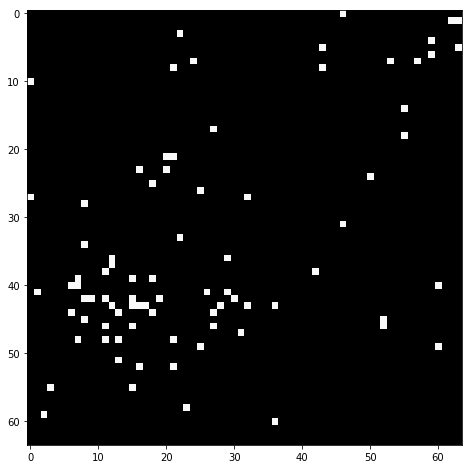

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import ndimage
file = './images/musician_BSOM_64_1000_305554.bmp'

image = ndimage.imread(file) 
plt.figure(figsize = (15,8))
plt.imshow(image)
image.shape

In [10]:
data, vocabulary, freqs, word_counts_per_snippet = calculate_frequencies()

print (freqs['war'])
print ('------')
print (sorted(freqs.items(), key=operator.itemgetter(1), reverse=True)[:5])
print ('------')
print (word_counts_per_snippet[5])
print ('------')
print("O vocabulário tem %d palavras"% len(vocabulary))

12943
------
[('id', 187689597180), ('the', 206265), ('include', 47477), ('time', 43436), ('state', 36749)]
------
Counter({'id': 608678, 'oil': 4, 'field': 2, 'divest': 2, 'interest': 2, 'the': 1, 'niger': 1, 'delta': 1, 'nembe': 1, 'creek': 1, 'discover': 1, 'produce': 1, 'middle': 1, 'miocene': 1, 'deltaic': 1, 'sandstone': 1, 'shale': 1, 'anticline': 1, 'structural': 1, 'trap': 1, 'depth': 1, 'shell': 1, 'announce': 1, 'strategic': 1, 'review': 1, 'operation': 1, 'nigeria': 1, 'hint': 1, 'asset': 1, 'while': 1, 'international': 1, 'company': 1, 'operate': 1, 'decades': 1, 'make': 1, 'move': 1, 'cite': 1, 'range': 1, 'issue': 1, 'include': 1, 'theft': 1, 'shell_oil_company': 1, 'say': 1, 'finalise': 1, 'nigerian': 1})
------
O vocabulário tem 262168 palavras


In [ ]:
#df_train = get_cleaned_data()
print (len(snippets_by_word['sunlight']))
#print (snippets_by_word['sunlight'][0:3])
#print (df_train.iloc[2497]['cleaned_text'])

H, W, N, rows = 64, 64, 1000, 305554    # Network height, width and unit dimensions
som_type = 'BSOM'
sufix = '_'+som_type+'_'+str(H)+'_'+str(N)+'_'+str(rows)
codebook = np.load('./serializations/codebook'+sufix+'.npy')
dataframe = pd.read_pickle('./serializations/dataframe'+sufix+'.pkl')
loader = np.load('./serializations/X'+sufix+'.npz')
print (' loading snippets_by_word'+sufix)   

som = Som(H, W, N, topology.RECT, verbose=True) # , verbose=True
som.codebook = codebook

#one possibility to speed up fingerprint generation is to pre-calculate bmus for each snippet (and save it to table)
#for idx, row in df_train.iterrows():
#    bmus = som.bmus(X[idx])
#    print (idx, bmus)
#    if idx > 100:
#        sys.exit(0)
    #idx = snippet_count['idx']
    #bmus = som.bmus(X[idx])